# Brock and Hommes model

In [1]:
%load_ext autoreload
%autoreload 2

In [199]:
from birds.models.brock_hommes import BrockHommes
from birds.calibrator import Calibrator
from birds.utils import soft_minimum, soft_maximum
from birds.forecast import simulate_and_observe_model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import normflows as nf
import pygtc
from corner import corner # to plot corner plots

In [47]:
class MMDLoss:
    def __init__(self, y):
        self.y = true_data[0]
        self.y_matrix = self.y.reshape(1,-1,1)
        self.y_sigma = torch.median(torch.pow(torch.cdist(self.y_matrix, self.y_matrix), 2))
        ny = self.y.shape[0]
        self.kyy = (torch.exp( - torch.pow(torch.cdist(self.y_matrix, self.y_matrix), 2) / self.y_sigma ) - torch.eye(ny)).sum() / (ny * (ny - 1))
        
    def __call__(self, x, y):
        nx = x.shape[0]
        x_matrix = x.reshape(1,-1,1)
        kxx = torch.exp( - torch.pow(torch.cdist(x_matrix, x_matrix), 2) / self.y_sigma )
        #kxx = torch.nan_to_num(kxx, 0.)
        kxx = (kxx - torch.eye(nx)).sum() / (nx * (nx - 1))
        kxy = torch.exp( - torch.pow(torch.cdist(x_matrix, self.y_matrix), 2) / self.y_sigma )
        #kxy = torch.nan_to_num(kxy, 0.)
        kxy = kxy.mean()
        return kxx + self.kyy - 2 * kxy

Following Dyer et al we fix

In [193]:
H = 4
log_r = np.log(1.0)
log_sigma = np.log(0.04)
g1, b1, b4, = 0, 0, 0
g4 = 1.01
log_beta = np.log(120)
n_timesteps = 100

class CustomBrockHommes(BrockHommes):
    def step(self, params, x):
        expanded_params = torch.tensor([log_beta, g1, 0, 0, g4, b1, 0, 0, b4, log_sigma, log_r])
        expanded_params[2] = params[0] # g2
        expanded_params[3] = params[1] # g3
        expanded_params[6] = params[2] # b2
        expanded_params[7] = params[3] # b2
        return super().step(expanded_params, x)
    
class UniformPrior(torch.distributions.Uniform):
    def log_prob(self, x):
        return super().log_prob(x).prod()
    
class TrainableGaussian(torch.nn.Module):
    def __init__(self, mus, sigma):
        super().__init__()
        self.mu = torch.nn.Parameter(mus)
        self.sigma = sigma

    def log_prob(self, x):
        dist = torch.distributions.MultivariateNormal(self.mu, self.sigma * torch.eye(self.mu.shape[0]))
        return dist.log_prob(x)

    def sample(self, x):
        dist = torch.distributions.MultivariateNormal(self.mu, self.sigma * torch.eye(self.mu.shape[0]))
        sample = dist.rsample((x,)) 
        return sample, dist.log_prob(sample)
    
class OldBrockHommes(torch.nn.Module):

    def __init__(self, n_timesteps=100, device="cpu"):
        super().__init__()
        self.n_timesteps = n_timesteps
        self._eps = torch.distributions.normal.Normal(
            torch.tensor([0.0], device=device), torch.tensor([1.0], device=device)
        )
        self.device = device

    def forward(self, params):
        """
        Runs the model forward. Parameters follow the order: log_beta, g1, g2, g3, g4, b1, b2, b3, b4, log_sigma, log_r

        !!! danger
        beta, sigma, and r are given in log.
        """
        beta = torch.exp(params[0])
        g = params[1:5]
        b = params[5:9]
        sigma = torch.exp(params[-2])
        r = torch.exp(params[-1])
        R = 1.0 + r

        #epsilons = self._eps.rsample((self.n_timesteps,))
        x = torch.zeros(3)
        for t in range(3, self.n_timesteps+3):
            exponent = (
                beta * (x[t - 1] - R * x[t - 2]) * (g * x[t - 3] + b - R * x[t - 2])
            )
            norm_exponentiated = torch.nn.Softmax(dim=-1)(exponent)
            mean = (norm_exponentiated * (g * x[t - 1] + b)).sum()
            x_t = (mean + self._eps.sample() * sigma) / R
            x = torch.hstack((x, x_t))
        return [x]
    
class OldCustomBrockHommes(OldBrockHommes):
    def forward(self, params):
        expanded_params = torch.tensor([log_beta, g1, 0, 0, g4, b1, 0, 0, b4, log_sigma, log_r])
        expanded_params[2] = params[0] # g2
        expanded_params[3] = params[1] # g3
        expanded_params[6] = params[2] # b2
        expanded_params[7] = params[3] # b2
        return super().forward(expanded_params)

In [194]:
model = CustomBrockHommes(n_timesteps)
model2 = OldCustomBrockHommes(n_timesteps)

In [202]:
g2 = 0.9
g3 = 0.9
b2 = 0.2
b3 = -0.2

true_parameters = torch.tensor([g2, g3, b2, b3])
torch.manual_seed(0)
x = model.run(true_parameters)
true_data = model.observe(x)

torch.manual_seed(0)
y = model2(true_parameters)

torch.manual_seed(0)
z = simulate_and_observe_model(model, params=true_parameters)


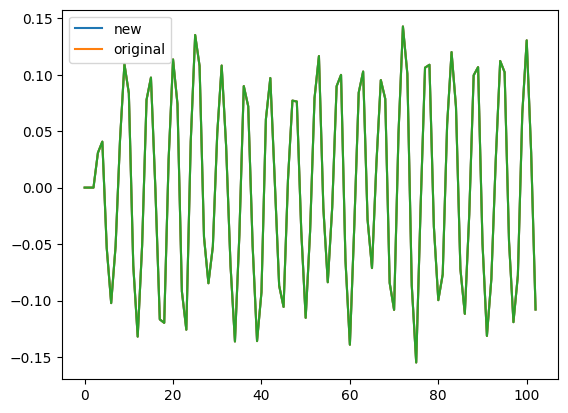

In [203]:
plt.plot(true_data[0].cpu(), label = "new")
plt.plot(y[0].cpu(), label = "original")
plt.plot(z[0].cpu())
plt.legend()

In [197]:
# Define flows
def make_flow1():
    base = nf.distributions.base.DiagGaussian(len(true_parameters))
    num_layers = 5
    latent_size = len(true_parameters)
    flows = []
    for i in range(num_layers):
        # Neural network with two hidden layers having 64 units each
        # Last layer is initialized by zeros making training more stable
        param_map = nf.nets.MLP([2, 50, 50, latent_size], init_zeros=True)
        # Add flow layer
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        # Swap dimensions
        flows.append(nf.flows.Permute(latent_size, mode='swap'))
    return nf.NormalizingFlow(base, flows)
    
def make_flow2():
    K = 16
    torch.manual_seed(0)
    
    latent_size = len(true_parameters)
    hidden_units = 64
    hidden_layers = 2
    
    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]
    
    # Set prior and q0
    q0 = nf.distributions.DiagGaussian(len(true_parameters), trainable=False)
        
    # Construct flow model
    nfm = nf.NormalizingFlow(q0=q0, flows=flows)
    return nfm
    

In [198]:
torch.manual_seed(0)
prior = torch.distributions.MultivariateNormal(torch.tensor([0.5, 0.5, 0.5, -0.5]), 1.0 * torch.eye(len(true_parameters)))
#estimator = TrainableGaussian(prior.loc, sigma=torch.tensor(0.25)) #make_flow1()
estimator = make_flow1()
optimizer = torch.optim.AdamW(estimator.parameters(), lr=1e-3)
calibrator = Calibrator(model = model, 
                        posterior_estimator = estimator, 
                        prior=prior, 
                        data=true_data, 
                        optimizer=optimizer, 
                        n_samples_per_epoch=10,
                        w=0.0,
                        forecast_loss = MMDLoss(true_data),
                        log_tensorboard=True,
                        gradient_estimation_method="score",
                        gradient_horizon=1)

calibrator.run(n_epochs=100000, max_epochs_without_improvement=np.inf);

  0%|                                                                                                                                                                                                  | 35/100000 [00:03<2:40:57, 10.35it/s, Forecast=0.295, Reg.=0, total=0.295, best loss=0.174, epochs since improv.=25]/Users/arnull/code/birds/birds/forecast.py:94: UserWarning: Simulation produced nan -- ignoring
  warnings.warn("Simulation produced nan -- ignoring")
  0%|                                                                                                                                                                                                  | 35/100000 [00:03<2:45:16, 10.08it/s, Forecast=0.295, Reg.=0, total=0.295, best loss=0.174, epochs since improv.=25]


AttributeError: 'float' object has no attribute 'detach'

In [29]:
# We can load the best model to check the results
estimator.load_state_dict(calibrator.best_model_state_dict)

<All keys matched successfully>

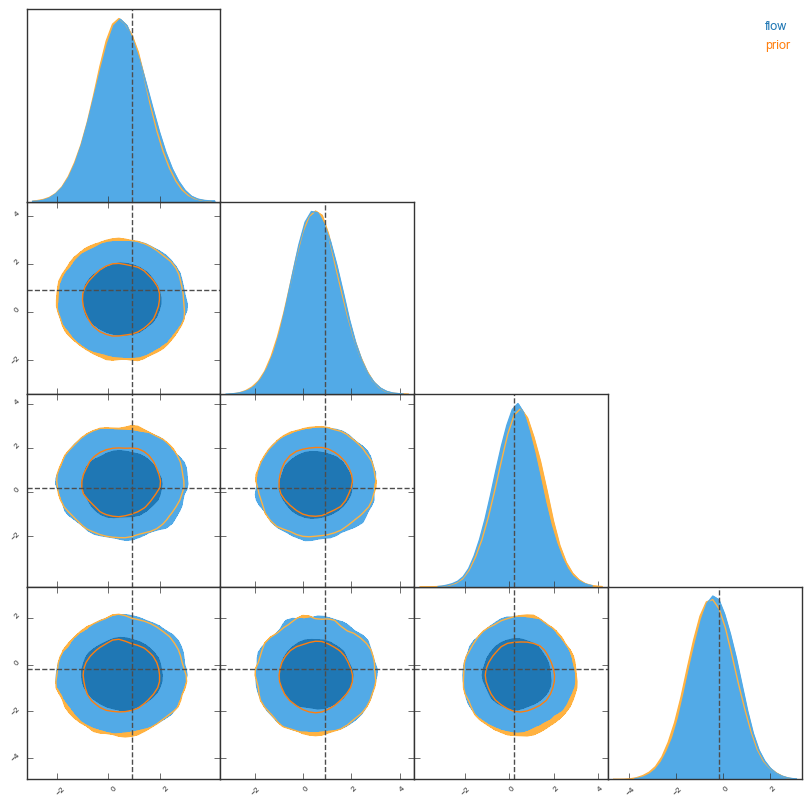

In [30]:
# Plot the final flow posterior approximator and compare it to the real parameters:
samples = estimator.sample(10000)[0].detach().numpy()
samples_prior = prior.sample((10000,)).numpy()

pygtc.plotGTC([samples, samples_prior], figureSize=10, truths = true_parameters.numpy(), chainLabels = ["flow", "prior"]);
#corner(samples, truths=true_parameters.numpy(), smooth=2);#, range=[(0,1) for i in range(3)]+ [(-1,0)]);

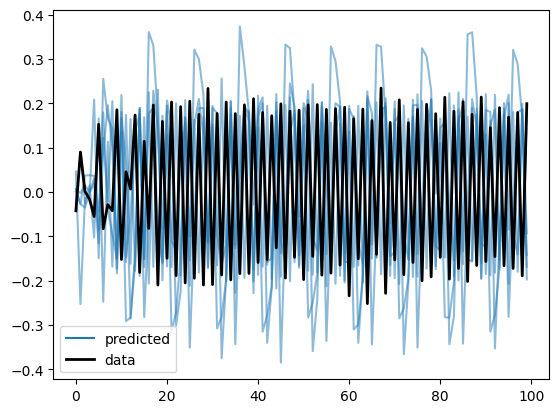

In [12]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(5):
    with torch.no_grad():
        sim = model(estimator.sample(1)[0][0])
    ax.plot(sim[0].numpy(), color = "C0", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data")

ax.legend()